# Создание циклической GAN для трансформации изображений в соответствии с визуальным стилем художников-импрессионистов

Основная цель данного проекта - разработать циклическую GAN для трансформации изображений

## Подготовка данных

Константы

In [1]:
IMAGE_SIZE = 256
BATCH_SIZE = 1
RESIDUAL_BLOCKS_NUM = 16
BASE_DIR = "/content/gdrive/MyDrive/CycleGAN/photo2impressionism/"
SAVING_PATH = "/content/gdrive/MyDrive/CycleGAN/lightning/photo2impressionism.ckpt"

Установка Pytorch Lightning

In [ ]:
!pip install pytorch-lightning

Импорт необходимых библиотек

In [ ]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer

from statistics import mean
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

Подключение к источнику данных

In [4]:
from google.colab import drive
 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Метод для загрузки картинок

In [5]:
def fetch_images(dirname):
    images = []
    for _, _, filenames in os.walk(BASE_DIR + dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = BASE_DIR + dirname + "/" + fname
                img = imread(fpath)
                image = resize(img, [IMAGE_SIZE, IMAGE_SIZE])
                images.append(image)
    images = np.array(images, np.float32)
    result = torch.from_numpy(images).permute(0, 3, 2, 1)
    return result

Загрузка картинок

In [6]:
photo_train = fetch_images("photo")
impressionism_train = fetch_images("impressionism")
photo_val = fetch_images("test_photo")
impressionism_val = fetch_images("test_impressionism")

Метод для отображения нескольких картинок

In [7]:
def print_images(imgs):
    images = imgs.permute(0, 3, 2, 1).numpy()
    plt.figure(figsize=(18, 6))
    for i in range(5):
        plt.subplot(2, 6, i+1)
        plt.axis("off")
        plt.imshow(images[i])

Печать первых 5 фотографий из валидационного датасета

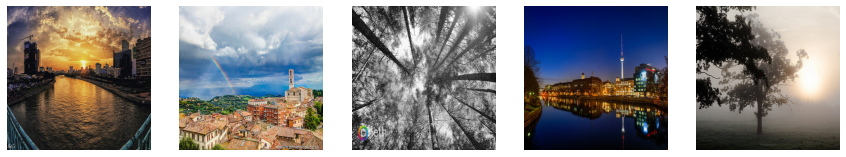

In [ ]:
print_images(photo_val[:5])

Печать первых 5 картин импрессионистов из валидационного датасета

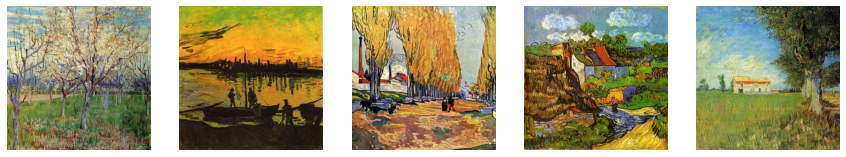

In [ ]:
print_images(impressionism_val[:5])

Создание загрузчиков данных

In [8]:
train_loader = DataLoader(
    dataset=list(zip(photo_train, impressionism_train)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    dataset=list(zip(photo_val, impressionism_val)),
    batch_size=BATCH_SIZE,
    num_workers=2
)

## Архитектура модели

### Методы создания слоев

Метод для создания сверточного слоя

In [9]:
def make_conv_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

Метод для создания разверточного слоя

In [10]:
def make_upsample_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=False)
    )

def make_deconv_layer(in_channels, out_channels):
    return nn.Sequential(
        make_upsample_layer(in_channels, out_channels),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

### Дискриминаторы

Дискриминаторы в данном случае - это сверточные нейронные сети, которые видят изображение и пытаются классифицировать его как реальное или поддельное.

In [11]:
class Discriminator(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            make_conv_layer(3, 16),
            make_conv_layer(16, 32),
            make_conv_layer(32, 64),
            make_conv_layer(64, 128),
            make_conv_layer(128, 256),
            make_conv_layer(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Генераторы

Генераторы в данном случае - нейросети, которые трансформируют изображения из одного типа в другой.

Остаточный блок

In [12]:
class ResidualBlock(LightningModule):
    
    def __init__(self, channels):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        x1 = self.layer_1(x)
        result = x + self.layer_2(x1)
        return result

Генератор

In [13]:
class Generator(LightningModule):
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            make_conv_layer(3, 16),
            make_conv_layer(16, 32),
            make_conv_layer(32, 64),
            make_conv_layer(64, 128),
            make_conv_layer(128, 256)
        )
        layers = [ResidualBlock(256)] * RESIDUAL_BLOCKS_NUM
        self.bottleneck = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            make_deconv_layer(256, 128),
            make_deconv_layer(128, 64),
            make_deconv_layer(64, 32),
            make_deconv_layer(32, 16),
            make_upsample_layer(16, 3),
            nn.Tanh()
        )

    def forward(self, x):
        e = self.encoder(x)
        b = self.bottleneck(e)
        result = self.decoder(b)
        return result

### Функции потерь

Функция потерь дискриминаторов для реальных картинок

In [14]:
def real_mse_loss(D_out):
    return torch.mean((D_out - 1) ** 2)

Функция потерь дискриминаторов для поддельных картинок

In [15]:
def fake_mse_loss(D_out):
    return torch.mean(D_out ** 2)

Функция потерь для реконструкции изображений генераторами

In [16]:
cycle_loss = nn.MSELoss()

### Код для тренировки модели

Контейнеры для хранения значений потерь

In [ ]:
photo_losses = []
impressionism_losses = []
cycle_losses = []
photo_losses_batch = []
impressionism_losses_batch = []
cycle_losses_batch = []

Код для тренировки модели

In [17]:
class TraiableCycleGAN(LightningModule):

    def __init__(self):
        super().__init__()

    def configure_optimizers(self):
        lr = 0.0002
        beta1 = 0.5
        beta2 = 0.999
        photo_optimizer = AdamW(self.photo_discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        impressionism_optimizer = AdamW(self.impressionism_discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        cycle_params = list(self.photo_generator.parameters()) + list(self.impressionism_generator.parameters())
        cycle_optimizer = AdamW(cycle_params, lr=lr, betas=(beta1, beta2))
        return [photo_optimizer, impressionism_optimizer, cycle_optimizer]

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        
        photo, impressionism = batch
        
        # train photo discriminator
        if optimizer_idx == 0:
            real_photo_loss = real_mse_loss(self.photo_discriminator(photo))
            fake_photo_loss = fake_mse_loss(self.photo_discriminator(self.photo_generator(impressionism)))
            loss = real_photo_loss + fake_photo_loss
            return loss
        
        # train impressionism discriminator
        if optimizer_idx == 1:
            real_impressionism_loss = real_mse_loss(self.impressionism_discriminator(impressionism))
            fake_impressionism_loss = fake_mse_loss(self.impressionism_discriminator(self.impressionism_generator(photo)))
            loss = real_impressionism_loss + fake_impressionism_loss
            return loss
        
        # train generators
        if optimizer_idx == 2:
            
            # compute photo generator loss
            out1 = self.photo_generator(impressionism)
            loss1 = real_mse_loss(self.photo_discriminator(out1))
        
            # compute impressionism cycle loss
            out2 = self.impressionism_generator(out1)
            loss2 = cycle_loss(out2, impressionism)

            # compute impressionism generator loss
            out3 = self.impressionism_generator(photo)
            loss3 = real_mse_loss(self.impressionism_discriminator(out3))

            # compute photo cycle loss
            out4 = self.photo_generator(out3)
            loss4 = cycle_loss(out4, photo)

            loss = loss1 + loss2 + loss3 + loss4
            return loss

    def validation_step(self, batch, batch_idx):
        
        photo, impressionism = batch

        # compute photo generator loss
        out1 = self.photo_generator(impressionism)
        loss1 = real_mse_loss(self.photo_discriminator(out1))
        photo_loss = fake_mse_loss(self.photo_discriminator(out1))
        photo_losses_batch.append(photo_loss.item())
        
        # compute impressionism cycle loss
        out2 = self.impressionism_generator(out1)
        loss2 = cycle_loss(out2, impressionism)

        # compute impressionism generator loss
        out3 = self.impressionism_generator(photo)
        loss3 = real_mse_loss(self.impressionism_discriminator(out3))
        impressionism_loss = fake_mse_loss(self.impressionism_discriminator(out3))
        impressionism_losses_batch.append(impressionism_loss.item())

        # compute photo cycle loss
        out4 = self.photo_generator(out3)
        loss4 = cycle_loss(out4, photo)

        loss = loss1 + loss2 + loss3 + loss4
        cycle_losses_batch.append(loss.item())
        return loss

    def on_epoch_end(self):
        if len(photo_losses_batch) > 0:
            photo_losses.append(mean(photo_losses_batch))
            impressionism_losses.append(mean(impressionism_losses_batch))
            cycle_losses.append(mean(cycle_losses_batch))
            photo_losses_batch.clear()
            impressionism_losses_batch.clear()
            cycle_losses_batch.clear()

### CycleGAN

In [18]:
class CycleGAN(TraiableCycleGAN):

    def __init__(self):
        super().__init__()
        self.photo_discriminator = Discriminator()
        self.impressionism_discriminator = Discriminator()
        self.photo_generator = Generator()
        self.impressionism_generator = Generator()

    def forward(self, x):
        return x

    @torch.no_grad()
    def generate_impressionism(self, photo):
        return self.impressionism_generator(photo)

    @torch.no_grad()
    def generate_photo(self, impressionism):
        return self.photo_generator(impressionism)

## Обучение

Тренировка модели на 500 эпохах

In [ ]:
photo_losses.clear()
impressionism_losses.clear()
cycle_losses.clear()
model = CycleGAN()
tr = Trainer(gpus=1, max_epochs=500)
tr.fit(model)
tr.save_checkpoint(SAVING_PATH)

Загрузка параметров тренированной GAN

In [19]:
model = CycleGAN.load_from_checkpoint(SAVING_PATH)

Графики значений потерь

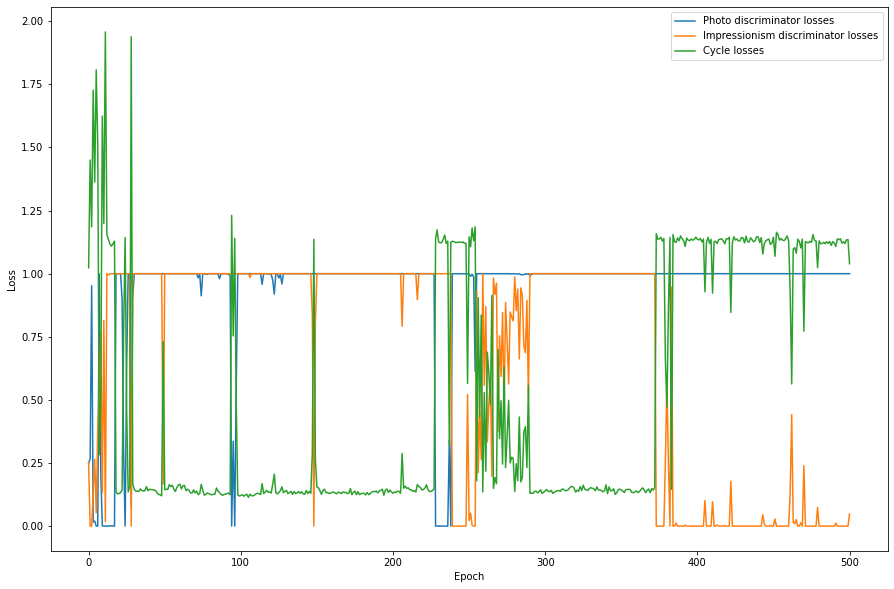

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(photo_losses)
plt.plot(impressionism_losses)
plt.plot(cycle_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Photo discriminator losses", "Impressionism discriminator losses", "Cycle losses"))
plt.show()

## Проверка реконструкции картинок

Проверка реконструкции летних фотографий

Выбор 5 картинок из валидационного датасета

In [20]:
photo = photo_val[5:10]

Печать картинок

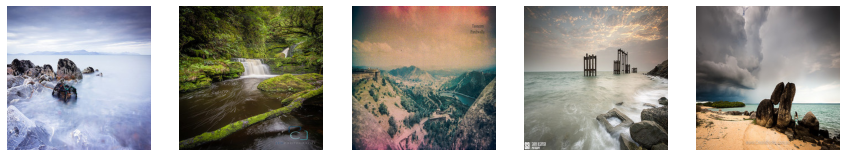

In [21]:
print_images(photo)

Реконструкция этих же картинок

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


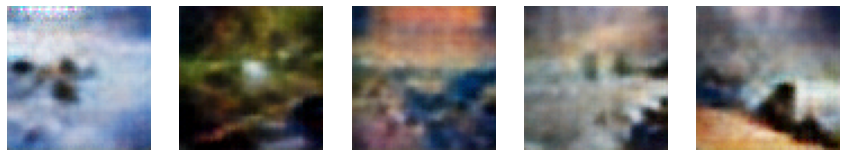

In [ ]:
impressionism = model.generate_impressionism(photo)
rec = model.generate_photo(impressionism)
print_images(rec)

Проверка реконструкции фотографий

Выбор 5 картинок из валидационного датасета

In [23]:
impressionism = impressionism_val[5:10]

Печать картинок

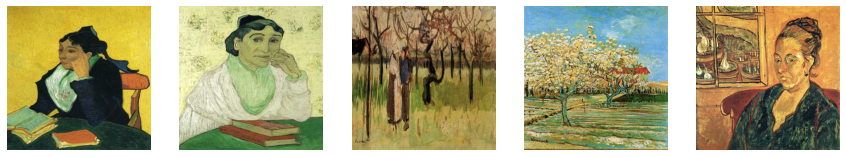

In [24]:
print_images(impressionism)

Реконструкция этих же картинок

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


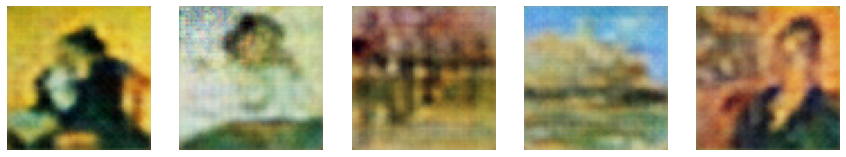

In [ ]:
photo = model.generate_photo(impressionism)
rec = model.generate_impressionism(photo)
print_images(rec)

## 1NN accuracy

Проверим качество трансформации изображений с помощью метода одного ближайшего соседа

Формирование выборки картинок

In [ ]:
flatten = nn.Flatten()
impressionism = flatten(impressionism_train)
generated = flatten(model.generate_impressionism(photo_train))
X = torch.cat((impressionism, generated)).numpy()

Формирование выборки классов

In [ ]:
zeros = torch.zeros(len(impressionism))
ones = torch.ones(len(impressionism))
y = torch.cat((ones, zeros)).numpy()

Обучение классификатора

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Подсчет accuracy score

In [ ]:
X_test = flatten(model.generate_impressionism(photo_val)).numpy()
y_pred = knn.predict(X_test)
score = int(mean(y_pred) * 10000) / 100
print("Accuracy score:", score, "%")

Accuracy score: 84.19 %


Поскольку результат превышает 80 %, GAN качественно генерирует изображения.

## Трансформация фотографий

Трансформация 5 картинок из летних в зимние

Исходные картинки

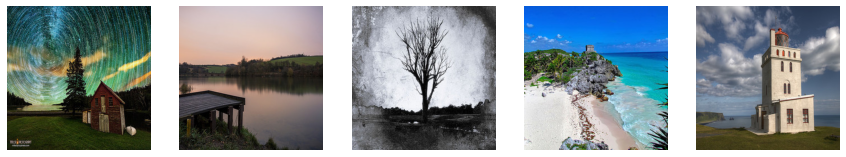

In [43]:
photo = photo_val[35:40]
print_images(photo)

Трансформированные картинки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


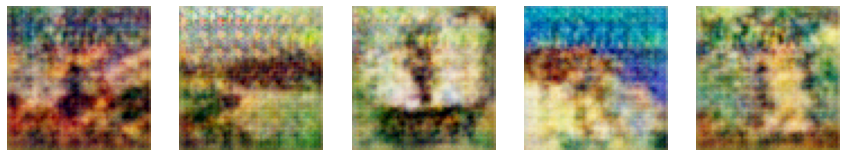

In [ ]:
print_images(model.generate_impressionism(photo))